In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
print(torch.cuda.is_available()) # should be True

t = torch.rand(10, 10).cuda()
print(t.device) # should be CUDA

True
cuda:0


In [ ]:
!pip install keras

In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=59cf7d4a9629d5bbcb21058ba2b3f6faeb90230c0f5707e0bb5a2be0f34a3c91
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import PIL
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from numpy import argmax
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import np_utils
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import librosa.display
from keras.callbacks import EarlyStopping
import time

import os

In [ ]:
# Kiểm tra các GPU có sẵn
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs available: {[gpu.name for gpu in gpus]}")
else:
    print("No GPUs available")

GPUs available: ['/physical_device:GPU:0']


In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
path = "./Spectrograms/"
categories = ['Ca_tru', 'Cai_luong', 'Cheo', 'Exception', 'Hat_ba_trao', 'Hat_chau_van', 'Hat_xoan', 'Ho',
              'Nhac_cung_dinh', 'Nhac_tai_tu', 'Quan_ho', 'Tuong','Xam']

In [ ]:
imagePaths = []
N_CHANNELS = 3
avg_f1 = []
avg_acc = []
avg_re = []
avg_pre = []
total_time = []
EPOCHS = 1000
INIT_LR = 1e-3
BS = 32
# Kích thước đầu vào cho mô hình
WIDTH, HEIGHT = 128, 128  # Đảm bảo rằng giá trị này đã được xác định

In [ ]:
class_names = categories
print(class_names)

['Ca_tru', 'Cai_luong', 'Cheo', 'Exception', 'Hat_ba_trao', 'Hat_chau_van', 'Hat_xoan', 'Ho', 'Nhac_cung_dinh', 'Nhac_tai_tu', 'Quan_ho', 'Tuong', 'Xam']


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)



# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình DenseNet121 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = DenseNet121(weights='imagenet', include_top=False)

# Thêm mô hình DenseNet121 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,353,869 (31.87 MB)

 Trainable params: 8,269,709 (31.55 MB)

 Non-trainable params: 84,160 (328.75 KB)

None


26000
[['./Spectrograms/Exception/10s_new/exception205.png', 3], ['./Spectrograms/Ho/10s_new/ho1501.png', 7], ['./Spectrograms/Hat_chau_van/10s_new/hatchauvan493.png', 5], ['./Spectrograms/Cheo/10s_new/cheo36.png', 2], ['./Spectrograms/Cheo/10s_new/cheo660.png', 2], ['./Spectrograms/Cai_luong/10s_new/cailuong977.png', 1], ['./Spectrograms/Exception/10s_new/exception245.png', 3], ['./Spectrograms/Ho/10s_new/ho347.png', 7], ['./Spectrograms/Hat_xoan/10s_new/hatxoan501.png', 6], ['./Spectrograms/Ca_tru/10s_new/catru745.png', 0]]
Total samples: 26000
Labels distribution: [2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000]


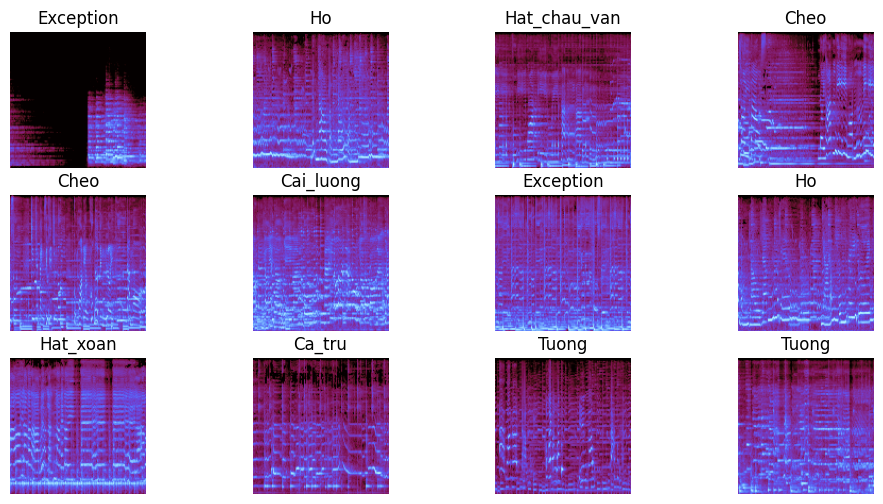

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imagePaths = []
data = []  # dữ liệu
labels = []  # nhãn
for k, category in enumerate(categories):
    for f in os.listdir(path+category+'/10s_new'):  # Thêm '/10s' vào đây
        imagePaths.append([path+category+'/10s_new'+'/'+f, k])

random.shuffle(imagePaths)
print(len(imagePaths))
print(imagePaths[:10])

import cv2
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

def process_image(imagePath):
    image = cv2.imread(imagePath[0])
    if image is not None:
        image = cv2.resize(image, (WIDTH, HEIGHT))
        return image, imagePath[1]
    else:
        print(f"Warning: Unable to read image {imagePath[0]}")
        return None, None

# Đọc ảnh song song
data = []
labels = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_image, path) for path in imagePaths]
    for future in futures:
        image, label = future.result()
        if image is not None:
            data.append(image)
            labels.append(label)

# Chuyển đổi dữ liệu và nhãn sang numpy arrays và chuẩn hóa
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# Kiểm tra số lượng mẫu và lớp
print(f"Total samples: {len(data)}")
print(f"Labels distribution: {np.bincount(labels)}")

# Hiển thị một số hình ảnh từ dữ liệu
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(data[i])
    plt.axis('off')
    plt.title(categories[labels[i]])
plt.show()



In [ ]:
(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

In [ ]:
start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/densenet121_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

Epoch 1/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 169s 65ms/step - accuracy: 0.4450 - loss: 34.6698 - val_accuracy: 0.8750 - val_loss: 15.7287 - learning_rate: 1.0000e-04
Epoch 2/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.8887 - loss: 13.1383 - val_accuracy: 0.9209 - val_loss: 7.2656 - learning_rate: 1.0000e-04
Epoch 3/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.9447 - loss: 6.0254 - val_accuracy: 0.9274 - val_loss: 3.3238 - learning_rate: 1.0000e-04
Epoch 4/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9581 - loss: 2.7042 - val_accuracy: 0.9339 - val_loss: 1.5409 - learning_rate: 1.0000e-04
Epoch 5/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9617 - loss: 1.2276 - val_accuracy: 0.9430 - val_loss: 0.7456 - learning_rate: 1.0000e-04
Epoch 6/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.9683 - loss: 0.5835 - val_accuracy: 0.9245 - val_loss: 0.5049 - learning_rate: 1.0000e-04
Epoch 7/1000
520/520 ━━━━━━━━━━━━━━━

Time: 1031.9440486431122


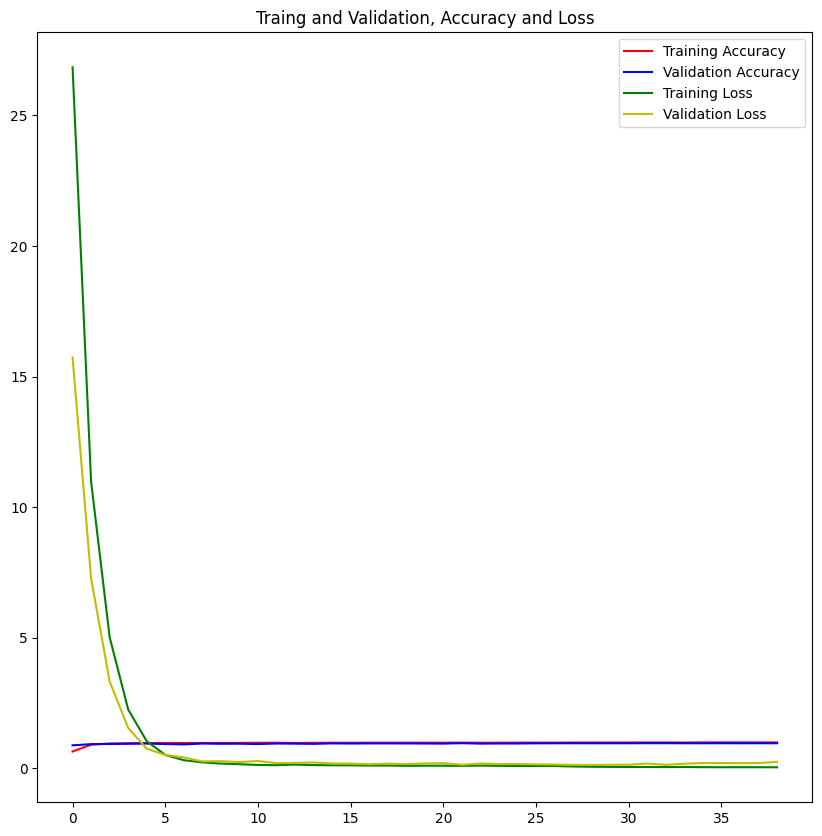

In [ ]:
# Plot the training and validation accuracy.

def plot_chart(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(10, 10))

    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')

    plt.title('Traing and Validation, Accuracy and Loss')
    plt.legend(loc=0)
    plt.show()

plot_chart(hist)

163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step


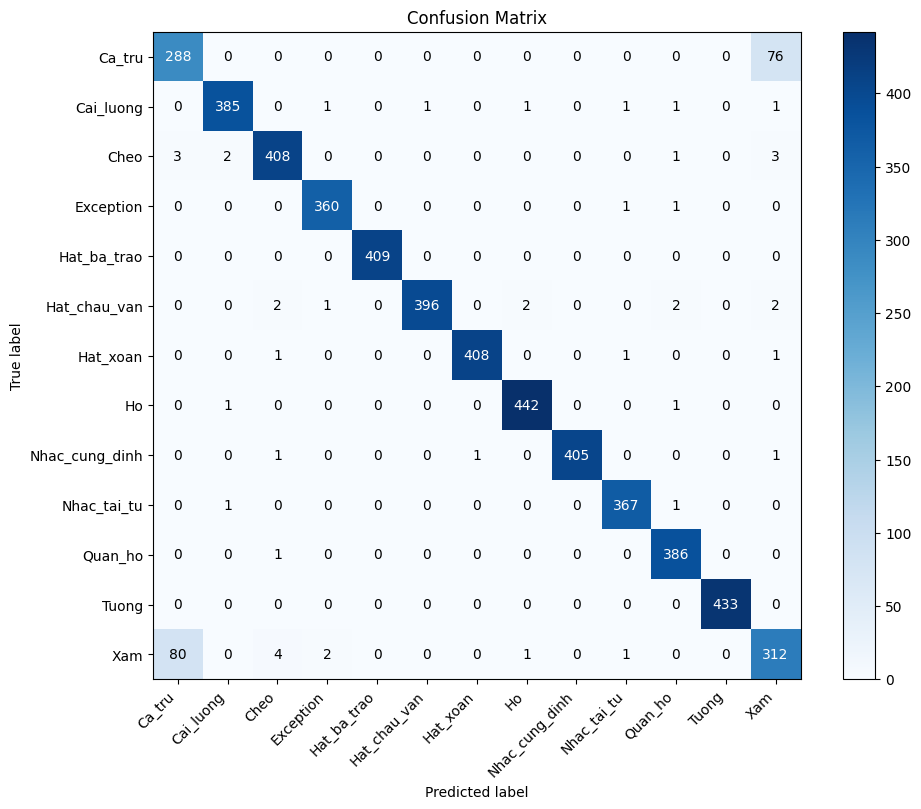

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

Accuracy : 96.13%


Recall :96.13%


Precision : 96.15%


F1 : 96.14%




In [ ]:
#Densenet121 BS24
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 24

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình DenseNet121 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = DenseNet121(weights='imagenet', include_top=False)

# Thêm mô hình DenseNet121 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/DenseNet121_128x128_bs24_10s_ver2.h5")
print(f'Time: {time.time() - start}')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,353,869 (31.87 MB)

 Trainable params: 8,269,709 (31.55 MB)

 Non-trainable params: 84,160 (328.75 KB)

None
Epoch 1/1000
694/694 ━━━━━━━━━━━━━━━━━━━━ 260s 173ms/step - accuracy: 0.4469 - loss: 32.8695 - val_accuracy: 0.8865 - val_loss: 13.5660 - learning_rate: 1.0000e-04
Epoch 2/1000
694/694 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.8843 - loss: 11.2092 - val_accuracy: 0.9144 - val_loss: 5.7760 - learning_rate: 1.0000e-04
Epoch 3/1000
694/694 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.9362 - loss: 4.6893 - val_accuracy: 0.9356 - val_loss: 2.3689 - learning_rate: 1.0000e-04
Epoch 4/1000
694/694 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.9524 - loss: 1.9106 - val_accuracy: 0.9332 - val_loss: 1.0590 - learning_rate: 1.0000e-04
Epoch 5/1000
694/694 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.9582 - loss: 0.8285 - val_accuracy: 0.9344 - val_loss: 0.5676 - learning_rate: 1.0000e-04
Epoch 6/1000
694/694 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.9564 - loss: 0.4392 - val_accuracy: 0.9368 - val_loss: 0.3716 - learning_rate: 1.0000e-04
Epoch 7/1000
694/694 ━━━━━━━━━

Time: 1433.5814144611359


163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step


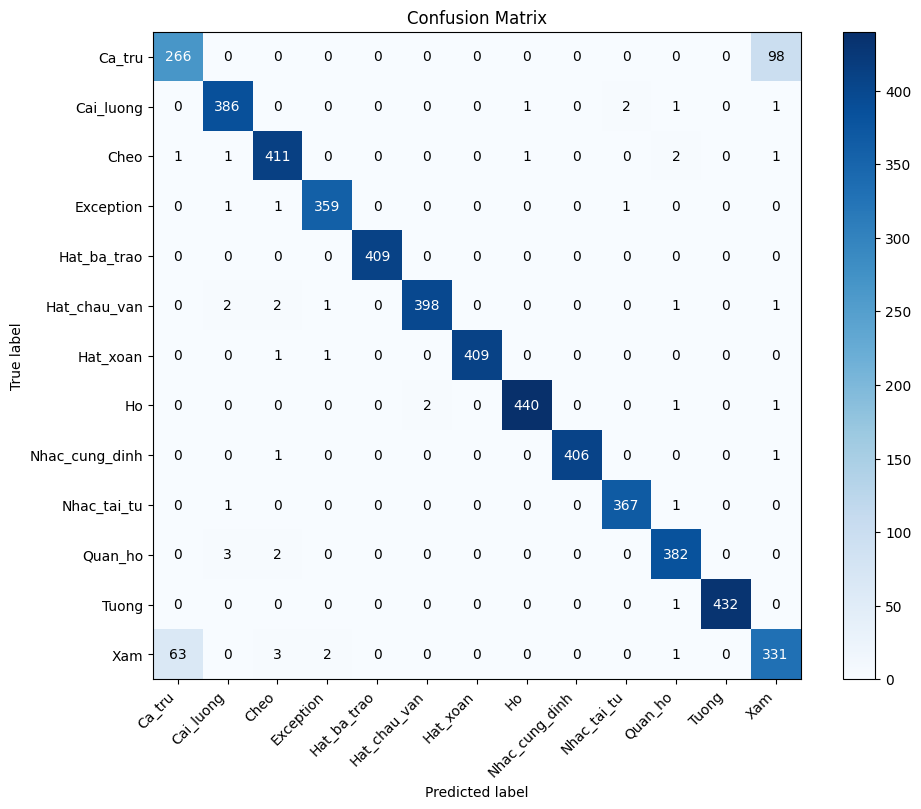

Accuracy : 96.08%


Recall :96.08%


Precision : 96.11%


F1 : 96.07%




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

In [ ]:
#DenseNet169 BS32
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 32

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình DenseNet169 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = DenseNet169(weights='imagenet', include_top=False)

# Thêm mô hình DenseNet169 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/DenseNet169_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 4, 4, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,704,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,614,605 (55.75 MB)

 Trainable params: 14,455,693 (55.14 MB)

 Non-trainable params: 158,912 (620.75 KB)

None
Epoch 1/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 235s 89ms/step - accuracy: 0.4927 - loss: 38.2101 - val_accuracy: 0.8849 - val_loss: 15.5635 - learning_rate: 1.0000e-04
Epoch 2/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.9104 - loss: 12.7205 - val_accuracy: 0.9296 - val_loss: 6.5411 - learning_rate: 1.0000e-04
Epoch 3/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.9492 - loss: 5.2971 - val_accuracy: 0.9238 - val_loss: 2.7243 - learning_rate: 1.0000e-04
Epoch 4/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.9611 - loss: 2.1384 - val_accuracy: 0.9224 - val_loss: 1.1951 - learning_rate: 1.0000e-04
Epoch 5/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.9673 - loss: 0.9100 - val_accuracy: 0.9286 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 6/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.9664 - loss: 0.4385 - val_accuracy: 0.9433 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 7/1000
520/520 ━━━━━━━━━━

Time: 1328.4355959892273


163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step


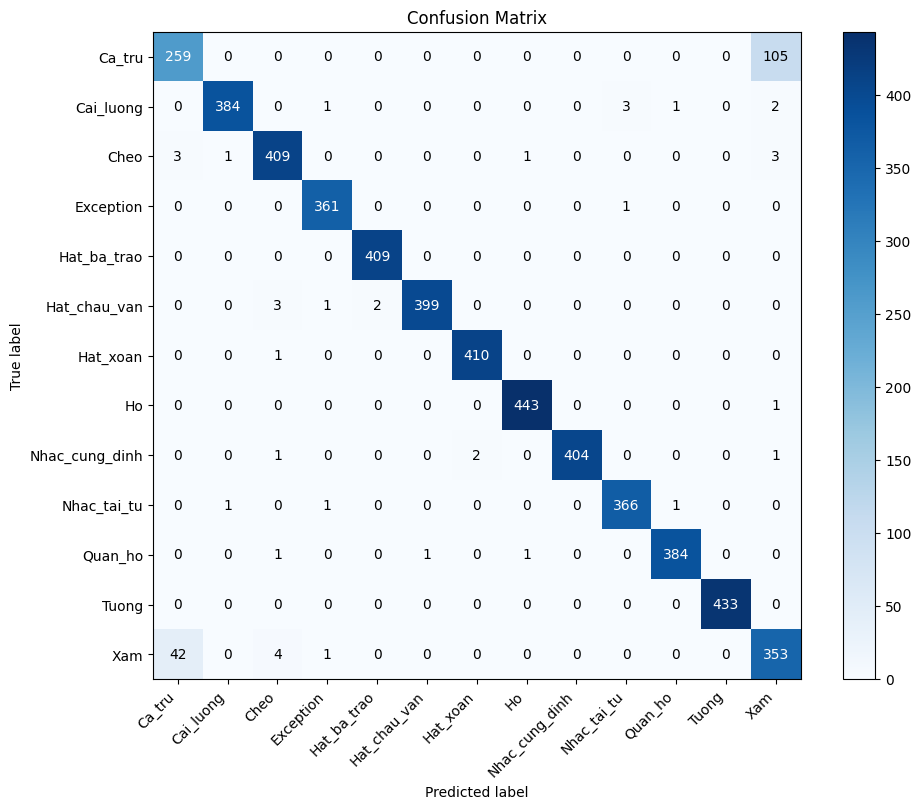

Accuracy : 96.42%


Recall :96.42%


Precision : 96.55%


F1 : 96.41%




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

In [ ]:
#DenseNet201 BS32
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 32

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình DenseNet201 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = DenseNet201(weights='imagenet', include_top=False)

# Thêm mô hình DenseNet201 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/DenseNet201_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1024)                │       1,967,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,555,853 (78.41 MB)

 Trainable params: 20,326,285 (77.54 MB)

 Non-trainable params: 229,568 (896.75 KB)

None
Epoch 1/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 316s 107ms/step - accuracy: 0.5205 - loss: 38.9128 - val_accuracy: 0.9043 - val_loss: 15.2478 - learning_rate: 1.0000e-04
Epoch 2/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9203 - loss: 12.4242 - val_accuracy: 0.9356 - val_loss: 6.2408 - learning_rate: 1.0000e-04
Epoch 3/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9540 - loss: 5.0169 - val_accuracy: 0.9260 - val_loss: 2.5218 - learning_rate: 1.0000e-04
Epoch 4/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9611 - loss: 1.9531 - val_accuracy: 0.9430 - val_loss: 1.0466 - learning_rate: 1.0000e-04
Epoch 5/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9682 - loss: 0.8054 - val_accuracy: 0.9293 - val_loss: 0.5675 - learning_rate: 1.0000e-04
Epoch 6/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9674 - loss: 0.4062 - val_accuracy: 0.9397 - val_loss: 0.3403 - learning_rate: 1.0000e-04
Epoch 7/1000
520/520 ━━━━━━━━━

Time: 1489.3687164783478


163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 117ms/step


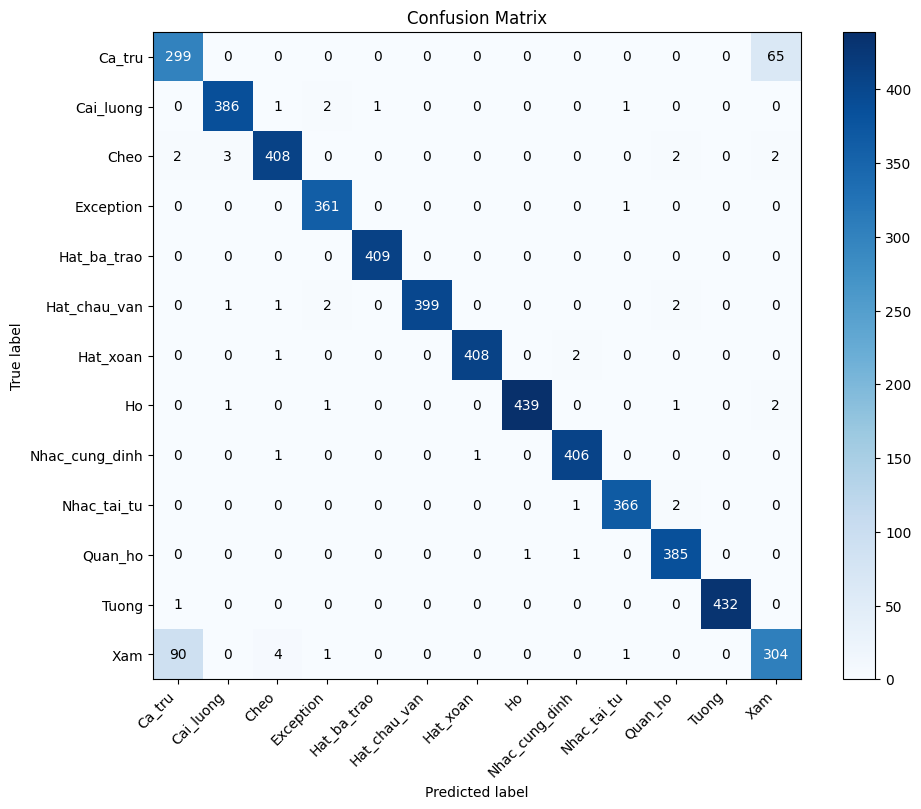

Accuracy : 96.19%


Recall :96.19%


Precision : 96.23%


F1 : 96.19%




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

<ipython-input-39-4888ff915826>:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,836,493 (14.64 MB)

 Trainable params: 3,801,869 (14.50 MB)

 Non-trainable params: 34,624 (135.25 KB)

None
Epoch 1/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 61s 27ms/step - accuracy: 0.4189 - loss: 41.8610 - val_accuracy: 0.4072 - val_loss: 24.6444 - learning_rate: 1.0000e-04
Epoch 2/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8266 - loss: 18.8759 - val_accuracy: 0.5452 - val_loss: 10.9572 - learning_rate: 1.0000e-04
Epoch 3/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9035 - loss: 7.5460 - val_accuracy: 0.6728 - val_loss: 4.6702 - learning_rate: 1.0000e-04
Epoch 4/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9365 - loss: 2.9698 - val_accuracy: 0.7567 - val_loss: 2.2565 - learning_rate: 1.0000e-04
Epoch 5/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9496 - loss: 1.2670 - val_accuracy: 0.8091 - val_loss: 1.3317 - learning_rate: 1.0000e-04
Epoch 6/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9585 - loss: 0.6085 - val_accuracy: 0.8555 - val_loss: 0.7993 - learning_rate: 1.0000e-04
Epoch 7/1000
520/520 ━━━━━━━━━━

Time: 423.1726121902466
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step


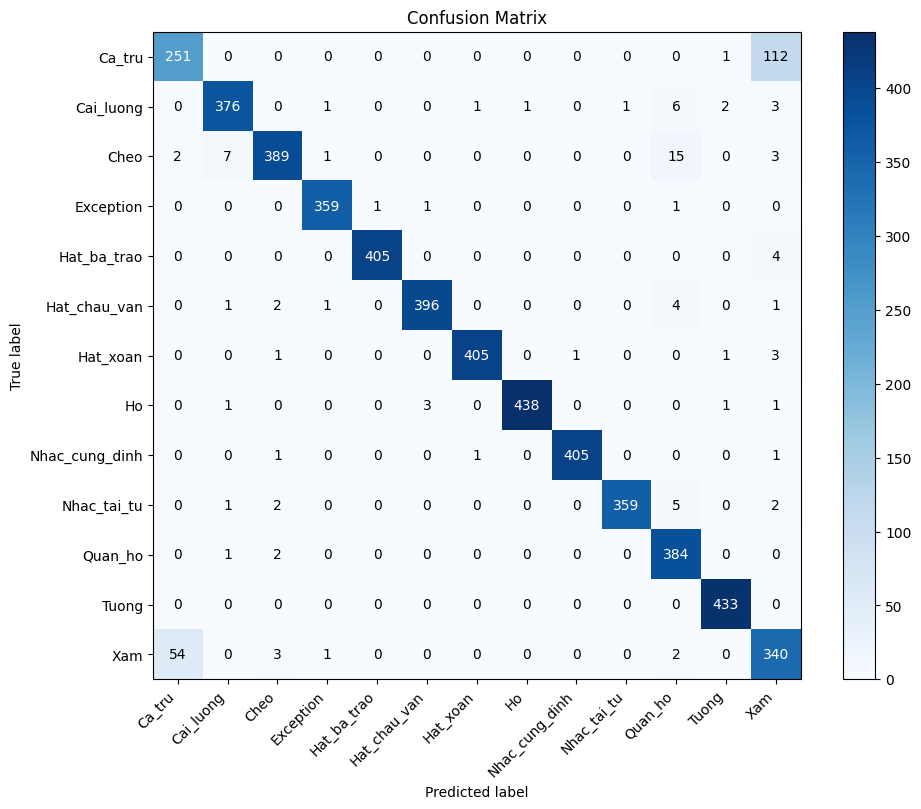

Accuracy : 95.00%


Recall :95.00%


Precision : 95.21%


F1 : 95.01%




In [ ]:
#MobileNetV2 BS32
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 32

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình MobileNetV2 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = MobileNetV2(weights='imagenet', include_top=False)

# Thêm mô hình MobileNetV2 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/MobileNetV2_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_101              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,167,725 (92.19 MB)

 Trainable params: 24,132,781 (92.06 MB)

 Non-trainable params: 34,944 (136.50 KB)

None
Epoch 1/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 107s 47ms/step - accuracy: 0.2729 - loss: 47.0484 - val_accuracy: 0.7118 - val_loss: 24.1393 - learning_rate: 1.0000e-04
Epoch 2/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.7215 - loss: 19.5639 - val_accuracy: 0.8200 - val_loss: 9.3440 - learning_rate: 1.0000e-04
Epoch 3/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8482 - loss: 7.4825 - val_accuracy: 0.8538 - val_loss: 3.7680 - learning_rate: 1.0000e-04
Epoch 4/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9043 - loss: 3.0196 - val_accuracy: 0.8709 - val_loss: 1.8099 - learning_rate: 1.0000e-04
Epoch 5/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9264 - loss: 1.3789 - val_accuracy: 0.8692 - val_loss: 1.0848 - learning_rate: 1.0000e-04
Epoch 6/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9410 - loss: 0.7232 - val_accuracy: 0.8870 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 7/1000
520/520 ━━━━━━━━━━

Time: 726.0681638717651
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step


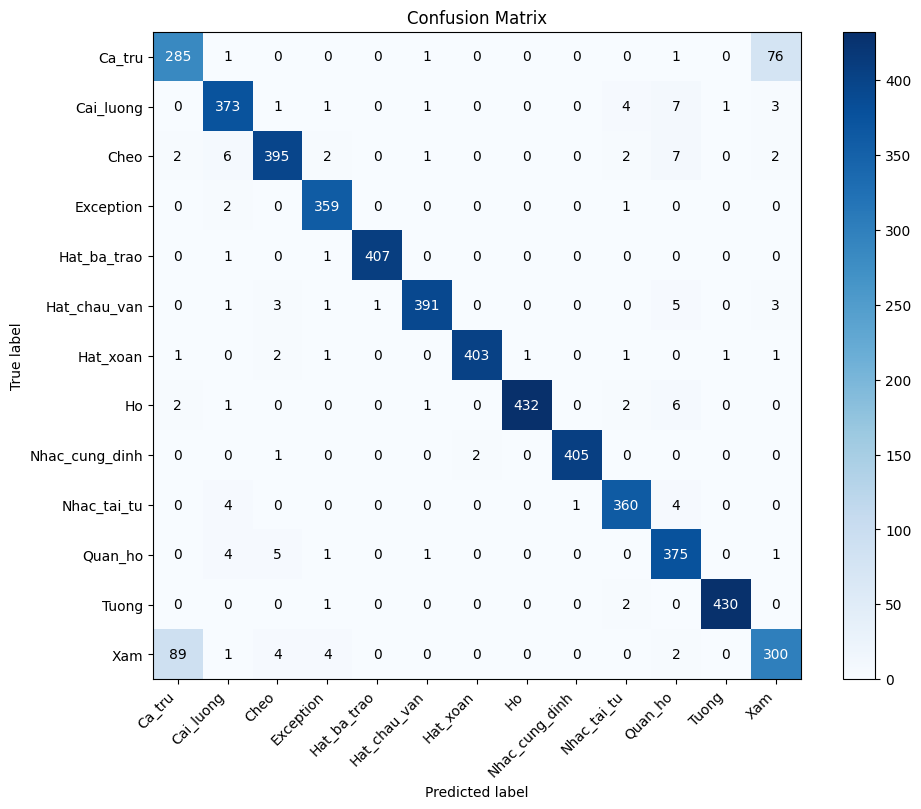

Accuracy : 94.52%


Recall :94.52%


Precision : 94.56%


F1 : 94.53%




In [ ]:
#InceptionV3 BS32
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 32

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình InceptionV3 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = InceptionV3(weights='imagenet', include_top=False)

# Thêm mô hình InceptionV3 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/InceptionV3_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 13)                  │           3,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,952,653 (99.00 MB)

 Trainable params: 25,899,021 (98.80 MB)

 Non-trainable params: 53,632 (209.50 KB)

None
Epoch 1/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 77s 40ms/step - accuracy: 0.5429 - loss: 45.4719 - val_accuracy: 0.0868 - val_loss: 26.5329 - learning_rate: 1.0000e-04
Epoch 2/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9134 - loss: 15.2210 - val_accuracy: 0.6572 - val_loss: 6.7593 - learning_rate: 1.0000e-04
Epoch 3/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9486 - loss: 4.4019 - val_accuracy: 0.9303 - val_loss: 1.8515 - learning_rate: 1.0000e-04
Epoch 4/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9510 - loss: 1.4333 - val_accuracy: 0.9409 - val_loss: 0.7670 - learning_rate: 1.0000e-04
Epoch 5/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9564 - loss: 0.6091 - val_accuracy: 0.9356 - val_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 6/1000
520/520 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9639 - loss: 0.3332 - val_accuracy: 0.9344 - val_loss: 0.3356 - learning_rate: 1.0000e-04
Epoch 7/1000
520/520 ━━━━━━━━━━━

Time: 728.0688543319702
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step


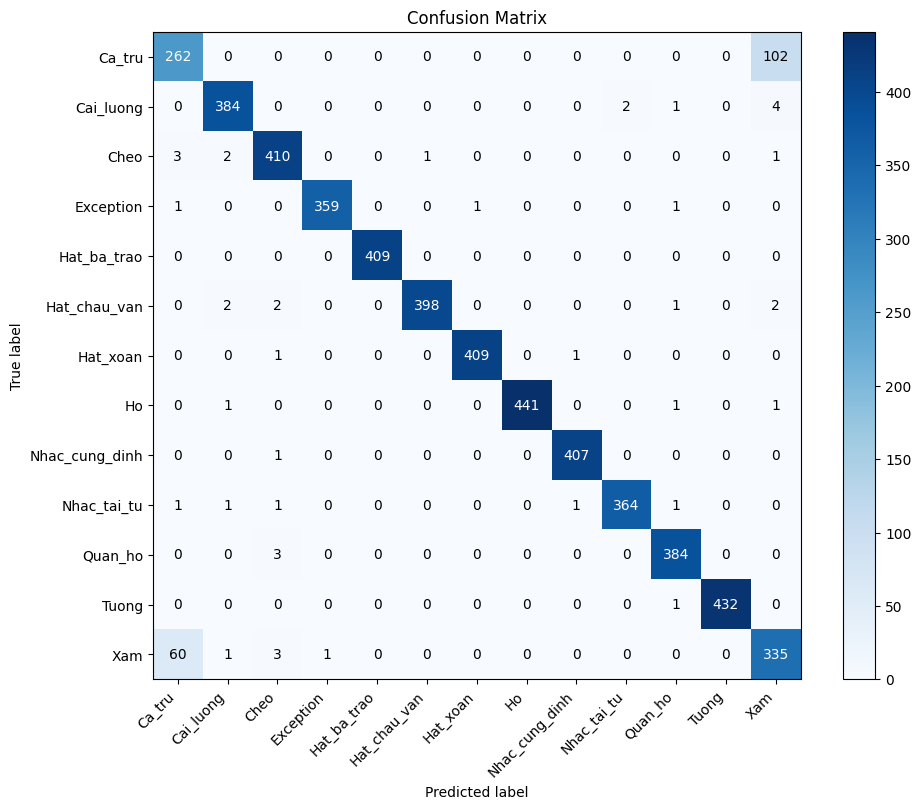

Accuracy : 96.04%


Recall :96.04%


Precision : 96.11%


F1 : 96.04%




In [ ]:
#ResNet50 BS32
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 32

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

# Tạo mô hình tuần tự
model = Sequential()

# Thêm lớp Input để xác định rõ kích thước đầu vào
model.add(Input(shape=(WIDTH, HEIGHT, 3)))

# Tạo mô hình ResNet50 với lớp Input layer để định nghĩa kích thước đầu vào
base_model = ResNet50(weights='imagenet', include_top=False)

# Thêm mô hình ResNet50 vào mô hình tuần tự
model.add(base_model)

# GlobalAveragePooling2D the output of the base_model
model.add(GlobalAveragePooling2D())

# Lớp fully connected với regularization
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.3))

# Lớp fully connected tiếp theo với regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.03)))
model.add(Dropout(0.2))

# Batch Normalization trước lớp cuối cùng
model.add(BatchNormalization())

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/ResNet50_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")

In [ ]:
#Lenet BS32
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BS = 32

# Định nghĩa số lượng lớp phân loại (số lượng nhãn)
num_classes = len(class_names)

model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same',
                        activation='relu', input_shape=(WIDTH, HEIGHT, 3)))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.25))
model.add(Convolution2D(filters=48, kernel_size=(
    5, 5), padding='valid', activation='relu'))
model.add(MaxPooling2D(strides=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# In ra cấu trúc của mô hình
print(model.summary())

(trainX, testX, trainY, testY) = train_test_split(
        data, labels, test_size=0.2, random_state=42)  # random_state=30)

trainY = keras.utils.to_categorical(trainY, len(categories))

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

hist = model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS,
                    verbose=1, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

model.save("Model/LeNet_128x128_bs32_10s_ver2.h5")
print(f'Time: {time.time() - start}')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập kiểm tra
pred = model.predict(testX)
predictions = np.argmax(pred, axis=1)  # chuyển đổi về nhãn

# Chuyển đổi nhãn thật về dạng nhãn nếu cần thiết
if testY.ndim > 1:
    true_labels = np.argmax(testY, axis=1)
else:
    true_labels = testY

# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predictions)

# Vẽ ma trận nhầm lẫn với tên lớp
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(categories))
plt.xticks(tick_marks, categories, rotation=45, ha='right')
plt.yticks(tick_marks, categories)

# Hiển thị giá trị trong từng ô của ma trận nhầm lẫn
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

accuracy = accuracy_score(testY, predictions)
# avg_acc.append(accuracy)
print("Accuracy : %.2f%%" % (accuracy*100.0))
print("\n")

# ----------------------------------------------

recall = recall_score(testY, predictions, average='weighted')
# avg_re.append(recall)
print("Recall :%.2f%%" % (recall*100))
print("\n")
# ----------------------------------------------

precision = precision_score(testY, predictions, average='weighted')
# avg_pre.append(precision)
print("Precision : %.2f%%" % (precision*100.0))
print("\n")
# ----------------------------------------------

f1 = f1_score(testY, predictions, average='weighted')
# avg_f1.append(f1)
print("F1 : %.2f%%" % (f1*100.0))
print("\n")